***
# Prototype Jupyter reporting
***

This first cell is about importing the 3 basic datasets from Power BI

**Combined** == The reduced data set that was precombined by the global team

**Incident** == Raw incident data with as many colums as it allowed me to export

**Service_Request** == Raw SR data with as many columns as it allowed me to export

On top of this, there is a function that will change format datetype columns and set a large number of columns to categorical instead of object.

Each of the datasets is imported into its own dataframe.

In [2]:
# Imports and Global variables.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#import missingno as msno
#import pandas_profiling
#import cufflinks as cf
#import plotly.offline

from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import output_notebook, save
from bokeh.resources import CDN
from bokeh.embed import file_html

import pickle

output_notebook()


#cf.go_offline()
#cf.set_config_file(offline=False, world_readable=True)

_DATASETS = {'Combined': 'WMA_Cmb_data.csv',
            'Incident': 'WMA_Inc_data.csv',
            'Service_Request': 'WMA_SR_data.csv'}

_HELPDESK = ['Elliott Beeten','Leigh Browning','Xyrus Roxas','Marc Falzon', 'Daniel Bowen']



Loading BokehJS ...

In [3]:
# Create some relative dates
# NB: requires work as it is still relative to current date and not solid date period

from datetime import datetime, date, timedelta
from dateutil import relativedelta
today = datetime.now()
currMonth = today.strftime('%Y %m')
print("Today's date:", currMonth)
previous = today + relativedelta.relativedelta(months=-1)
print(f"Previous Month: {previous.strftime('%Y %m')}")
sixmonth = today + relativedelta.relativedelta(months=-6)
print(f"Six Month: {sixmonth.strftime('%Y %m')}")
sixmonth = sixmonth.strftime('%Y %m')
print(sixmonth)

Today's date: 2020 11
Previous Month: 2020 10
Six Month: 2020 05
2020 05


## Functions to be used

Functions are as follows:
* **import_dataset** - Used to import CSVs into dataframes
* **date_breakdown** - Used on dataframes to expand out CreatedOn and ResolvedOn fields for date components
* **base_data_plot** - Creates a temp dataframe for base data counts and plots using Bokeh
* **plots_per_hour** - Creates a temp dataframe and plots tickets logged per hour for days of the week and months

In [4]:
# Function to break down Created and Resolved datetimes into easily worked components
# There is likely a better way to do this, but at the moment it works
# Components are:
# - Year (eg. 2019)
# - Month (eg. 3)
# - Day (eg. 26)
# - Day Name (eg. Tuesday)
# - Time (eg. 10:32:45)
# - Hour (eg. 14.00)
# - Month Name (eg. October)
# - Period (eg. 2019-03-26)


def date_breakdown(df, period):
    period_sets = {'Day':'D','Month':'M','Quarter':'Q', 'Year':'A'}
    
    df = df.assign(CreatedOn_year=df.CreatedOn.dt.year,
        CreatedOn_month=df.CreatedOn.dt.month,
        CreatedOn_day=df.CreatedOn.dt.day,
        CreatedOn_day_name=df.CreatedOn.dt.day_name(),
        CreatedOn_time = df.CreatedOn.dt.time,
        CreatedOn_hour = df.CreatedOn.dt.hour,
        CreatedOn_month_name = df.CreatedOn.dt.month_name(),
        ResolvedOn_year=df.ResolvedOn.dt.year,
        ResolvedOn_month=df.ResolvedOn.dt.month,
        ResolvedOn_day=df.ResolvedOn.dt.day,
        ResolvedOn_day_name=df.ResolvedOn.dt.day_name(),
        ResolvedOn_time = df.ResolvedOn.dt.time,
        ResolvedOn_hour = df.ResolvedOn.dt.hour,
        ResolvedOn_month_name = df.ResolvedOn.dt.month_name(),
        TicketDuration=(df['ResolvedOn'] - df['CreatedOn']).dt.days,
        Created_month_name = df.CreatedOn.dt.month_name(),
        Resolved_month_name = df.ResolvedOn.dt.month_name(),
        Created_period = df.CreatedOn.dt.to_period(period_sets.get(period, 'Day')),
        Resolved_period = df.ResolvedOn.dt.to_period(period_sets.get(period, 'Day')),
        Ticket_Type = df.RequestID.str[:2],
        FCR = (df.ResolvedOn - df.FirstAssignedOn)/np.timedelta64(1,'h') < 3
      )
    return df

In [5]:
def import_dataset(report, period):    
    
    df = pd.read_csv(f'./{_DATASETS[report]}')

    # Change Date columns to date type
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                df[col] = pd.to_datetime(df[col]).dt.tz_localize('UTC').dt.tz_convert('Australia/Sydney')

            except ValueError:
                pass

    # Change categorical columns to column        
    cat_list = ['Status', 'SupportGroup', 'Urgency', 'Impact', 'AffectedUser', 'AffectedUserCompany',
                'AssignedToUser', 'AssignedToUserCompany', 'CreatedByUser', 'CreatedByUserCompany',
                'ResolvedByUser', 'ResolvedByUserCompany', 'Source', 'ResolutionCategory', 'Classification',
                'AffectedUserLocalSupport','AffectedUserOffice ', 'AssignedToUserLocalSupport', 'AssignedToUserOffice',
               'CreatedByUserLocalSupport', 'CreatedByUserOffice', 'ImplementationResults', 'Priority', 'SLOStatus',
                ]

    for cat in cat_list:
        try:
            df[cat] = df[cat].astype('category')
        except:
            pass
        
    df = date_breakdown(df, period)
        
    return df

In [6]:
def base_data_plot(df):

    df = df[df.AssignedToUser.isin(_HELPDESK)]
    df = df[df.CreatedOn > sixmonth]


    # organse seperate df for monthly rundown
    df_combined = pd.DataFrame(
        {'Created': df.RequestID[(df.Created_period != currMonth)&(df.Resolved_period != currMonth)].groupby(df.Created_period).count(),
        'Resolved': df.RequestID[(df.Created_period != currMonth)&(df.Resolved_period != currMonth)].groupby(df.Resolved_period).count(),
        'Mean Dur':df.TicketDuration[(df.Created_period != currMonth)&(df.Resolved_period != currMonth)].groupby(df.Resolved_period).mean(),
        'Max Dur': df.TicketDuration[(df.Created_period != currMonth)&(df.Resolved_period != currMonth)].groupby(df.Resolved_period).max(),
        'On': df.RequestID[(df.Title.str.contains('Onboarding actions'))&(df.Created_period != currMonth)&(df.Resolved_period != currMonth)].groupby(df.Created_period).count(),
        'Off': df.RequestID[(df.Title.str.contains('Offboarding actions'))&(df.Created_period != currMonth)&(df.Resolved_period != currMonth)].groupby(df.Created_period).count(),
        'Inc': df.RequestID[(df.Ticket_Type == 'IR')&(df.Created_period != currMonth)&(df.Resolved_period != currMonth)].groupby(df.Created_period).count(),
        'SR': df.RequestID[(df.Ticket_Type == 'SR')&(df.Created_period != currMonth)&(df.Resolved_period != currMonth)].groupby(df.Created_period).count(),
        'FCR': df.RequestID[(df.Ticket_Type=='IR')&(df.Created_period != currMonth)&(df.Resolved_period != currMonth)&(df.FCR == True)].groupby(df.Resolved_period).count(),
        'FCR %': (df.RequestID[(df.Ticket_Type=='IR')&(df.Created_period != currMonth)&(df.Resolved_period != currMonth)&(df.FCR == True)].groupby(df.Resolved_period).count()/df.RequestID[(df.Ticket_Type=='IR')&(df.Created_period != currMonth)&(df.Resolved_period != currMonth)].groupby(df.Resolved_period).count())*100,
        }
    )
    plt.style.use('ggplot')
    print(df_combined)

    # print each column as a seperate plot
    df_combined.plot(subplots=True, figsize=[15,25], linewidth=3, sharex=False)
    df_combined.plot(y=['On', 'Off'], figsize=[12, 7], linewidth=3)
    # plt.axhline(y=df_combined['Onboarding'].median(), linestyle="--")
    df_combined.plot(y=['Created', 'Resolved'], figsize=[12, 7], linewidth=3)
    df_combined.plot(y=['Mean Dur', 'Max Dur'], figsize=[12, 7], linewidth=3)
    # plt.axhline(y=40, linestyle="--")
    df_combined.plot(y=['Inc', 'SR'], figsize=[12, 7], linewidth=3)
    
    tools = "box_zoom, undo, crosshair"
    p = figure(plot_width=800, x_axis_type='datetime', tools = tools)
    source = ColumnDataSource(df_combined)
    p.line(x='index', y='Created', source=source, color='Red', legend="Opened", )
    p.line(x='index', y='Resolved', source=source, color='Green', legend="Closed")
    p.line(x='index', y='On', source=source, color='Navy', legend="New Starters")
    p.line(x='index', y='Off', source=source, legend="Leavers")
    p.line(x='index', y='Inc', source=source, color='Pink', legend="Inc")
    p.line(x='index', y='SR', source=source, color='Orange', legend="SR")
    p.legend.click_policy='hide'
    
    p.add_tools(
    HoverTool(
        tooltips=[('value','$y'), 
                  ('Date', '@index')]
    )
)
    # output_file('First_Plot.html')
    show(p)

In [7]:
def plots_per_hour(temp_df):

    temp_df = temp_df[temp_df.AssignedToUser.isin(_HELPDESK)]
    temp_df = temp_df[temp_df.CreatedOn > sixmonth]

    
    fig, axs = plt.subplots(nrows=2, figsize=(10, 15))
    sns.stripplot(x='CreatedOn_day_name', y=temp_df.CreatedOn.dt.hour, data=temp_df, alpha=0.2,
               order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'], ax=axs[0])
    plt.xlabel("Days")

    
    sns.swarmplot(x='CreatedOn_month_name', y='CreatedOn_hour', data=temp_df, alpha=0.5, hue='AssignedToUser',
            order=['August','September','October','November','December','January'],
            hue_order=['Leigh Browning','Elliott Beeten','Xyrus Roxas'],ax=axs[1])
    plt.xlabel("Days")

# sort=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
    plt.show()
    #df_incident_dates = df_incident_dates.set_index(df_incident_dates.CreatedOn.values).sort_index()

***
## Cells to run
***

Each cell will be used to run above functions


In [8]:
# Create basic DataFrames
# This cell is required for there to be any data available.
period='Month'

# df_combined = import_dataset('Combined', 'Day') # Power BI Combined Data
df_incident = import_dataset('Incident', period) # Power BI all Incident Data
df_service_request = import_dataset('Service_Request', period) # PowerBI all Service Request Data
df_concat = pd.concat([df_service_request, df_incident], ignore_index=True, sort=True) # Joining of df_incident and df_service_request
                                                                    # data for a more thorough dataset

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


In [9]:
# Incidents
df_created_inc = df_incident.set_index(df_incident.CreatedOn.values).sort_index()
df_resolved_inc = df_incident.set_index(df_incident.ResolvedOn.values).sort_index()

# Service Requests
df_created_sr = df_service_request.set_index(df_service_request.CreatedOn.values).sort_index()
df_resolved_sr = df_service_request.set_index(df_service_request.ResolvedOn.values).sort_index()

# Concatenated
df_created_con = df_concat.set_index(df_concat.CreatedOn.values).sort_index()
df_resolved_con = df_concat.set_index(df_concat.ResolvedOn.values).sort_index()

In [10]:
# Creates a table displaying first resolver and total.
# NB: Not currently working but an idea to come back and fix

FCR_user = df_resolved_con[(df_resolved_con['ResolvedOn'] - df_resolved_con['FirstAssignedOn'])/np.timedelta64(1,'h') < 1].groupby('AssignedToUser').count()
FCR_user

,AffectedUser,AffectedUserCompany,AffectedUserLocalSupport,AffectedUserOffice,AgeInDays,AssignedToUserCompany,AssignedToUserLocalSupport,AssignedToUserOffice,Classification,ClosedOn,...,SLOTarget,SRCount,Source,Status,SupportGroup,TicketDuration,Ticket_Type,Title,Urgency,WorkItemDimKey
AssignedToUser,,,,,,,,,,,,,,,,,,,,,
Ajeesh S,23,23,23,23,23,23,23,23,23,22,...,23,20,23,23,23,23,23,23,23,23
Aloma Nichols,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,1,1,1
Audrey Zeze,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,1,1,1
Avinash Varma,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Brabin Kumar,3,3,3,3,3,3,3,3,3,3,...,3,1,3,3,3,3,3,3,3,3
Charleen Love,2,2,2,2,2,2,2,2,2,2,...,2,0,2,2,2,2,2,2,2,2
Daniel Bowen,5,5,4,5,5,5,0,5,5,4,...,5,0,5,5,5,5,5,5,5,5
Elliott Beeten,1260,1260,1163,1260,1260,1260,1260,1260,1260,1226,...,1249,323,1242,1260,1260,1260,1260,1260,1260,1260
Fleur Williamson,3,3,3,3,3,3,3,3,3,2,...,3,1,3,3,3,3,3,3,3,3


***
## Existing report for quick graphs
***

Below cell is existing report for 6 charts using the combined (yet reduced) dataset out of Power BI

This will generate new fields that are a break down of date parts as well as a field to designate IR vs SR


***
## Bohek testing for interactive plots
***

This area is for testing inline bokeh plots

         Created  Resolved  Mean Dur  Max Dur    On   Off  Inc   SR  FCR  \
2020-05      278       255  1.521569     15.0  10.0  37.0  123  155   57   
2020-06      257       264  2.450758     42.0   8.0  45.0  102  155   67   
2020-07       26        34  5.647059     43.0   NaN   NaN    8   18    7   

             FCR %  
2020-05  50.892857  
2020-06  63.207547  
2020-07  53.846154  


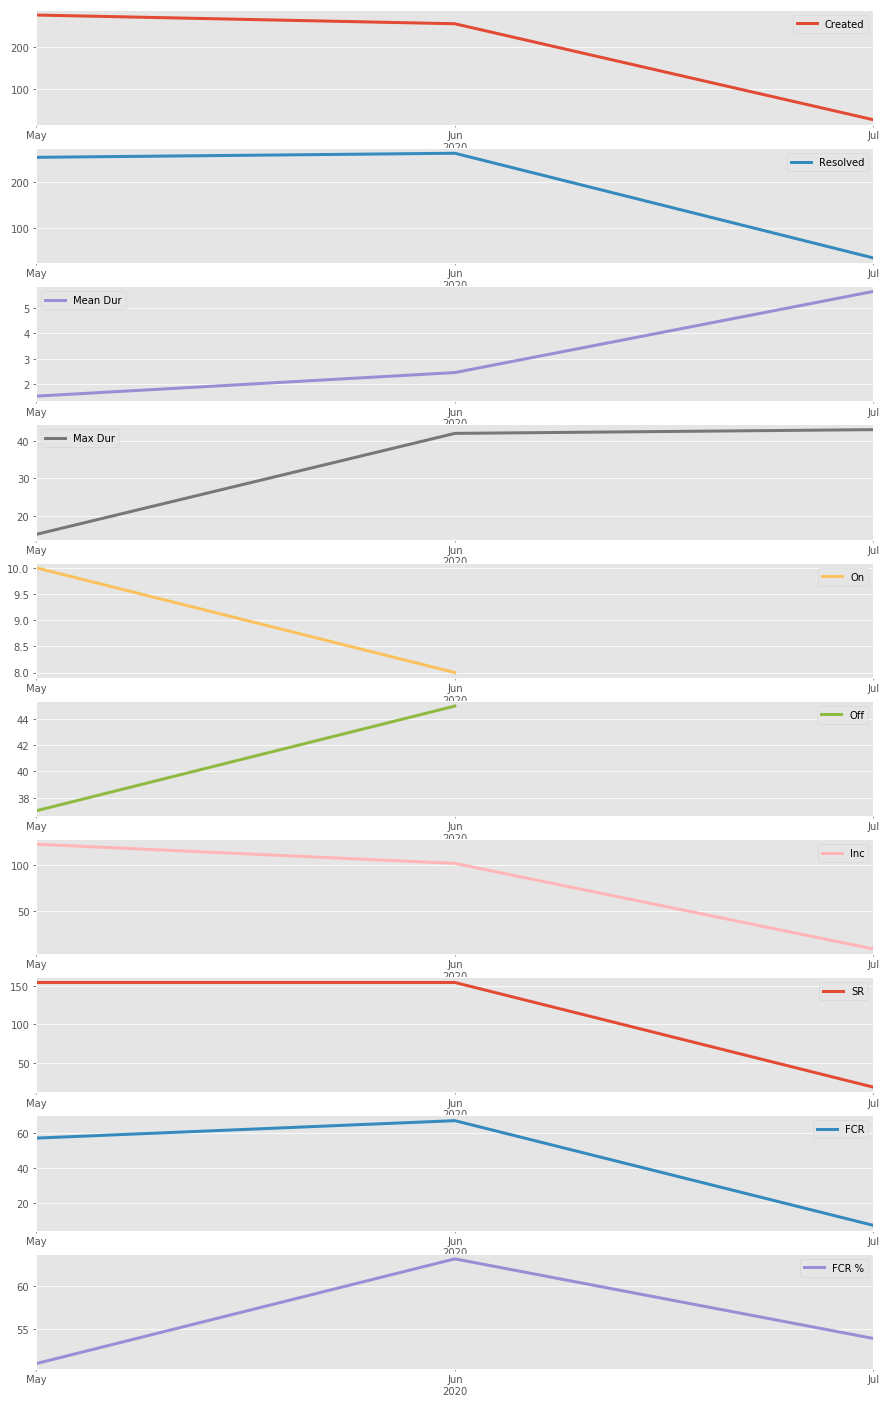

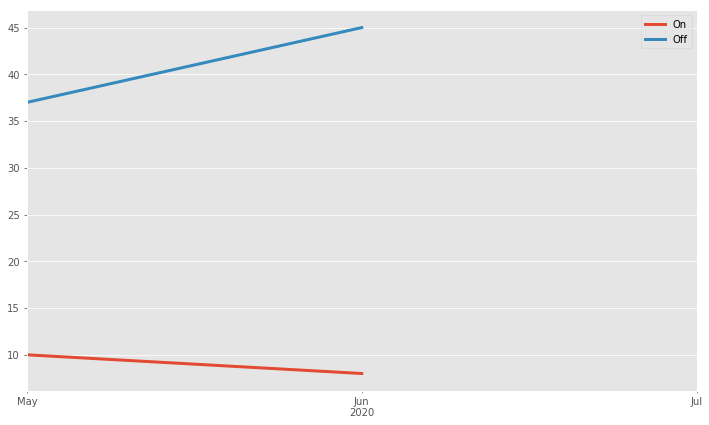

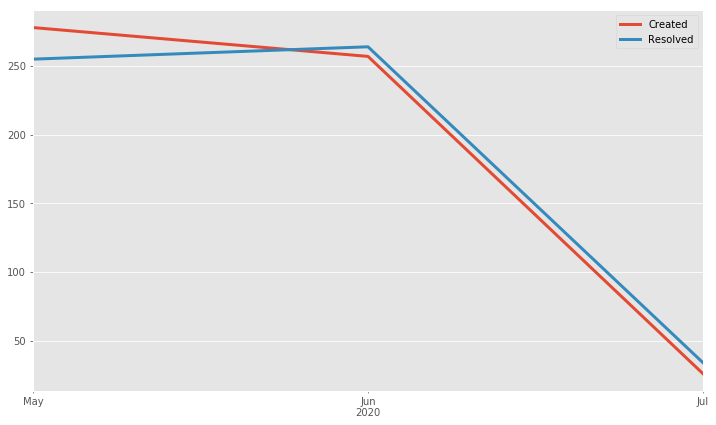

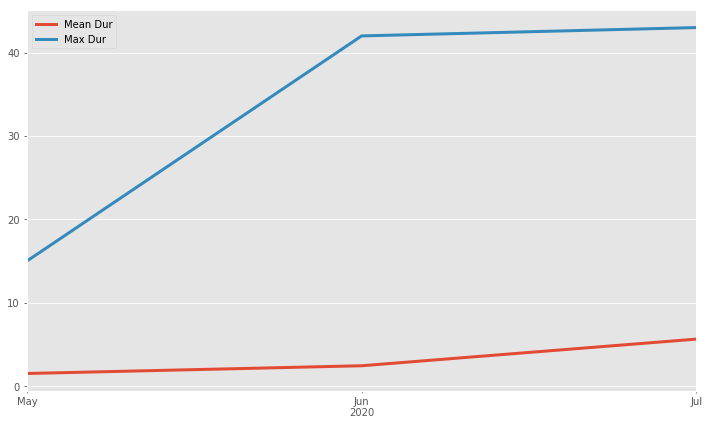

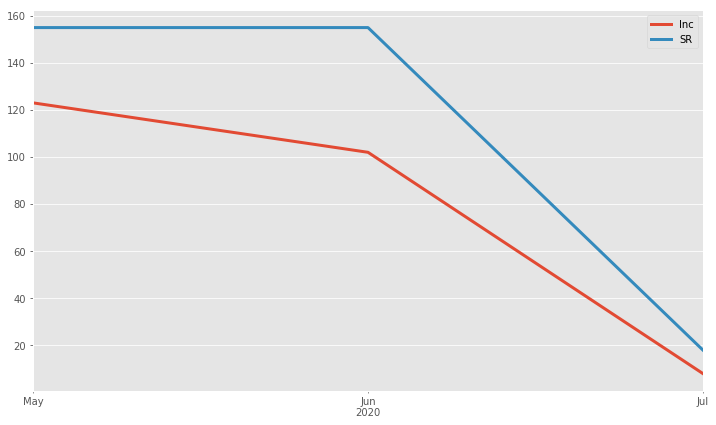

In [11]:
# Run base data plot function against dataframe
# Plots Created vs Resolved
# Plots Mean vs Max Durations
# Plots Onboarding vs Offboarding
# Plots Incidents vs Service Requests

# Works for df_incident and df_service_requests, but not df_concat (which is just a concatination of the previous two)

base_data_plot(df_concat)


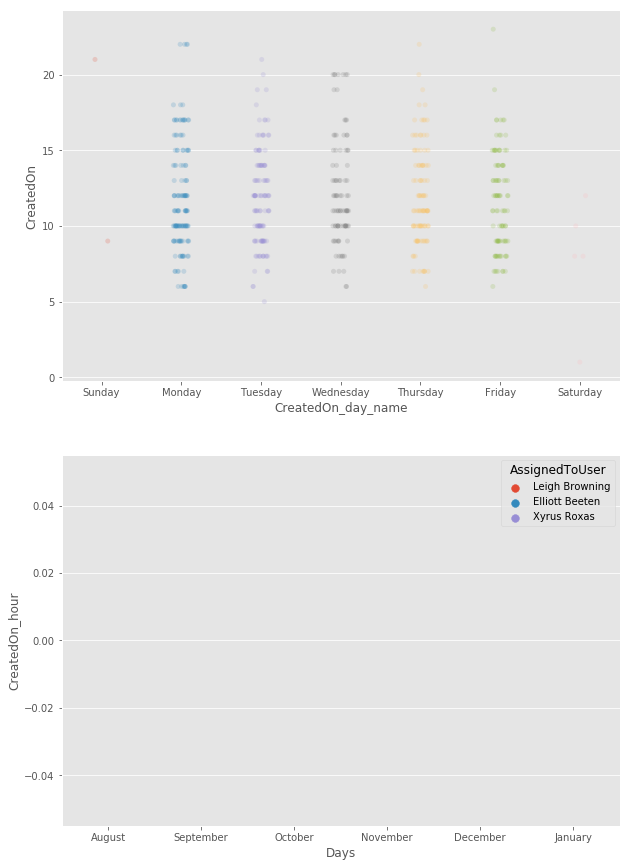

In [12]:
plots_per_hour(df_concat)

In [13]:
df_concat.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12790 entries, 0 to 12789
Data columns (total 63 columns):
AffectedUser                  12790 non-null object
AffectedUserCompany           12790 non-null category
AffectedUserLocalSupport      12066 non-null object
AffectedUserOffice            12790 non-null object
AgeInDays                     12790 non-null int64
AssignedToUser                12581 non-null object
AssignedToUserCompany         12561 non-null object
AssignedToUserLocalSupport    12529 non-null object
AssignedToUserOffice          12565 non-null object
Classification                12773 non-null object
ClosedOn                      11750 non-null datetime64[ns, Australia/Sydney]
CompletionNotes               1841 non-null object
CreatedByUser                 6258 non-null object
CreatedByUserCompany          6258 non-null object
CreatedByUserLocalSupport     6104 non-null object
CreatedByUserOffice           6258 non-null object
CreatedOn                     12790 n

In [14]:
# Find 10 most common words in tickets for the month
df = df_concat

# df_temp = df[(df.CreatedOn_month == previous.month) & (df.CreatedOn_year == previous.year)]
df_temp = df[(df.CreatedOn_month == previous.month) & (df.CreatedOn_year == previous.year)] # & (df.CreatedOn_day == 18)

# df_temp = df

words = []
from collections import Counter

for i in range(len(df_temp)):
    temp = df_temp.iloc[i]['Title'].lower().split(' ')
    temp = [*filter(str.isalnum, temp)]
    words.extend(temp)
    
my_words = Counter(words)

for word in ['as','in','the','and','to','for', 'not', 'on', 'from', 'by', 'actions']:
    if my_words[word]:
        del my_words[word]
        
my_words.most_common(15)
temp = pd.DataFrame(my_words.most_common(15))
temp

""


In [15]:
df_temp = df[(df.CreatedOn_month == previous.month) & (df.CreatedOn_year == previous.year)]
# df_temp = df

categories = []
from collections import Counter

for i in range(len(df_temp)):
    temp = df_temp.iloc[i]['Source']
    categories.append(temp)

my_categories = Counter(categories)
temp = pd.DataFrame(my_categories.most_common(10))
temp


""


In [16]:
df_temp = df[(df.CreatedOn_month == previous.month) & (df.CreatedOn_year == previous.year) & (df.CreatedOn_day == 11)]
cats = Counter(df_temp['Classification'])
temp = pd.DataFrame(cats.most_common(10))
temp

""


In [17]:
df.query("AssignedToUser in ['Elliott Beeten','Leigh Browning','Xyrus Roxas','Marc Falzon', 'Daniel Bowen']").shape

(7682, 63)

In [18]:
df = df_concat
df_temp = df[(df.CreatedOn_month == previous.month) & (df.CreatedOn_year == previous.year) & (df.CreatedOn_day == 11)]
test = df_temp.groupby('CreatedOn_hour')['Ticket_Type'].count().plot()



TypeError: Empty 'DataFrame': no numeric data to plot

In [ ]:
# df[(df.CreatedOn >= '2020-05-18') & (df.CreatedOn <= '2020-05-18')]
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

temp_df = df[(df.AssignedToUser.isin(_HELPDESK)) &(df.CreatedOn_month == previous.month) & (df.CreatedOn_year == previous.year)][['Title', 'CreatedOn', 'RequestID', 'Source']]
temp_df = temp_df[(temp_df.CreatedOn.dt.day_name().isin(['Sunday', 'Saturday']))
        | (~temp_df.CreatedOn.dt.day_name().isin(['Sunday', 'Saturday'])
        & (~temp_df.CreatedOn.dt.hour.isin([7,8,9,10,11,12,13,14,15,16,17])))]
temp_df['Day_of_week'] =temp_df.CreatedOn.dt.day_name()
temp_df['Day_of_week'] = pd.Categorical(temp_df['Day_of_week'], categories=
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
    ordered=True)
temp_df.groupby(['Day_of_week', 'Source']).count().dropna()

In [ ]:
# Count of tickets per day by Source

temp_df = df[df.AssignedToUser.isin(_HELPDESK)]
temp_df = temp_df[(temp_df.CreatedOn_month == previous.month) & (temp_df.CreatedOn_year == previous.year)][['AssignedToUser', 'CreatedOn', 'CreatedOn_day', 'RequestID', 'Source', 'Classification']]
# temp_df.groupby(['CreatedOn_day','Source']).count()
pd.pivot_table(temp_df, index='CreatedOn_day', columns='Source', values='RequestID', aggfunc = [lambda x: x.count()]).plot()

## Machine Learning runs
Starting with a vectorization (checking both count and tfidf) against a cured dataset of around 1000 titles and descriptions.

In [19]:
df_concat[['Title','Description','Ticket_Type']].to_csv('./filtered_dataset.csv')



In [5]:
#df_concat[['Title','Description','Ticket_Type']].shape
# df_concat.columns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd

ml_test = pd.read_csv('./filtered_dataset_trained.csv')
print(ml_test.shape)

ml_test.info()
ml_test.dropna(subset=['Title', 'Description', 'Training_Type'],inplace=True)
print(ml_test.shape)

X = ml_test['Description'].str.lower().str.replace('[^a-zA-Z\s\@]', '')
y = ml_test['Training_Type'].str.upper()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# X_train, y_train, X_test, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=123)



(12790, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12790 entries, 0 to 12789
Data columns (total 5 columns):
ID               12790 non-null int64
Title            12790 non-null object
Description      11098 non-null object
Ticket_Type      12790 non-null object
Training_Type    1030 non-null object
dtypes: int64(1), object(4)
memory usage: 499.7+ KB
(917, 5)
(641,)
(276,)
(641,)
(276,)


In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pickle

cv = CountVectorizer(stop_words='english')
count_train = cv.fit_transform(X_train)
count_test = cv.transform(X_test)

print(cv.get_feature_names()[:10])

tfidf = TfidfVectorizer(stop_words='english')
tfidf_train = tfidf.fit_transform(X_train)
tfidf_train_alpha = lambda X_train: X
tfidf_test = tfidf.transform(X_test)

print(tfidf.get_feature_names()[:10])

pickle.dump(tfidf, open('tfidf_vactor.sav', 'wb'))





['aakbary', 'aaron', 'aaronakbary', 'aaronroberts', 'aaronsmith', 'aaronwu', 'aballe', 'abdo', 'abdolhi', 'abdollahi']
['aakbary', 'aaron', 'aaronakbary', 'aaronroberts', 'aaronsmith', 'aaronwu', 'aballe', 'abdo', 'abdolhi', 'abdollahi']


In [31]:
# Model train using Count Vectoriser

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(count_test)

# Calculate the accuracy score: score
score = accuracy_score(y_test, pred)
print(score)
cm =confusion_matrix(y_test, pred, labels=['IR', 'SR'])
print(cm)

0.7934782608695652
[[ 97  18]
 [ 39 122]]


In [30]:
# Model train using TFIDF vectoriser

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
import pickle



# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(tfidf_train, y_train)

#pickle ML model for later use.
filename = 'finalized_model.sav'
pickle.dump(nb_classifier, open(filename, 'wb'))

# Create the predicted tags: pred
pred = nb_classifier.predict(tfidf_test)

# Calculate the accuracy score: score
score = accuracy_score(y_test, pred)
print(score)
cm =confusion_matrix(y_test, pred, labels=['IR', 'SR'])
print(cm)

0.8152173913043478
[[ 80  35]
 [ 16 145]]


In [10]:
new_test = pd.read_csv('./incident.csv')
new_test['description'] = new_test['description'].str.lower().str.replace('[^a-zA-Z\s\@]', '')
print(new_test.shape)
print(new_test.info())
print(new_test.head())



(1481, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1481 entries, 0 to 1480
Data columns (total 16 columns):
number               1481 non-null object
state                1481 non-null object
opened_at            1481 non-null object
short_description    1481 non-null object
caller_id            1481 non-null object
location             1481 non-null object
contact_type         1481 non-null object
priority             1481 non-null object
category             1473 non-null object
assignment_group     1481 non-null object
assigned_to          1429 non-null object
u_division           1481 non-null object
sys_updated_on       1481 non-null object
sys_updated_by       1481 non-null object
business_duration    1481 non-null int64
description          1481 non-null object
dtypes: int64(1), object(15)
memory usage: 185.2+ KB
None
       number   state       opened_at  \
0  INC0024202  Closed  1/10/2020 0:02   
1  INC0024216  Closed  1/10/2020 2:19   
2  INC0024220  Closed  1/10/20

In [11]:
#import saved ML model and vector
import pickle
filename = 'finalized_model.sav'
nb_classifier = pickle.load(open(filename, 'rb'))
tfidf = pickle.load(open('tfidf_vactor.sav', 'rb'))

# load new file data to test
new_test = pd.read_csv('./incident.csv')
new_test['description'] = new_test['description'].str.lower().str.replace('[^a-zA-Z\s\@]', '')


tfidf_new = tfidf.transform(new_test['description'])
new_preds = nb_classifier.predict(tfidf_new)

from collections import Counter

counts = Counter(new_preds)
print(counts)

Counter({'SR': 852, 'IR': 629})


In [12]:
new_test['results'] = new_preds
new_test[['short_description','description', 'results']].sample(20)

,short_description,description,results
671,Workday password reset - Rubens De Bouchersville,workday password reset rubens de bouchersville,IR
1388,teams??????,are you aware of anyone else impacted with the...,IR
1200,Microsoft Teams,hi service desk\ni am unable to get messages f...,IR
1363,Request for password reset.,hi syed\n\ntech system shows incorrect passwor...,IR
1474,Node down | th003-og-asw01.cloud.weir | TH001 ...,alert node down thogaswcloudweir th bangko...,SR
457,Trouble connecting to Wifi in Brisbane.,alicia advises that a number of people and dev...,IR
744,Printer not working after coming back to office,printer not working after coming back to office,IR
1101,Fwd: Capex System Update - Action Required - Y...,best regards\r\nlokesh bhatia\r\n\r\nsent from...,SR
683,Mouse stops clicking mid way through modifying...,mouse stops clicking mid way through modifying...,SR
1246,Technology SVN Issue,hi\n\nim unable to access the mapped svn folde...,IR


In [32]:
new_test[['short_description','description', 'results']].sample(20)


,short_description,description,results
181,SAP Concur - mobile APP,hi team\n\ni cant log onto my sap concur mobil...,SR
135,Slow Emails,no worries will pop down this morning\n\nkind ...,SR
227,Inoke Luani- SAP password,hi it\n\ncan you please reset inoke luanis sap...,IR
59,Email Setup on iPhone,lindy has called\r\n noting that she needs as...,IR
276,Software Installation,am jordan thomsonlarkins\r\n hey elliot ne...,SR
24,Josue Morales,hi\n\ni accidently broke my head phone for tea...,SR
130,Weir Mackay - Printer Access Denied,hello\n\ni have been printing this morning but...,SR
417,Elastomer Team Leader Computer/Laptop,hello\n\ncan i please have a laptop urgently f...,SR
352,MS Team Not working,forwarded by sateeshbabuvaradaraju@mailweir\n\...,IR
217,Mobile Phone Issue & Whatsapp,tom has called\r\n noting that his company mo...,IR
